**Assignment 2**

In [255]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)


Generate Synthetic Dataset with RANDOM Class Centers

In [256]:
def generate_synthetic_data(n_per_class=200, num_classes=5):
    # 🟣 Generate random class centers
    centers = np.random.randint(-10, 10, size=(num_classes, 2))  # RANDOM

    X_list = []
    y_list = []

    for class_idx in range(num_classes):
        cx, cy = centers[class_idx]
        X_class = np.random.randn(n_per_class, 2) + np.array([cx, cy])
        y_class = np.full(n_per_class, class_idx)

        X_list.append(X_class)
        y_list.append(y_class)

    X = np.vstack(X_list)
    y = np.hstack(y_list)

    # Shuffle dataset
    perm = np.random.permutation(len(X))
    return X[perm], y[perm], centers

X, y, centers = generate_synthetic_data()
print("Random Class Centers:\n", centers)


Random Class Centers:
 [[  2   5]
 [-10  -7]
 [ -7  -3]
 [ -1   9]
 [  8  -6]]


In [257]:
#Train/Test Split
N = X.shape[0]
n_train = int(0.8 * N)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

print("Train size:", len(X_train))
print("Test size :", len(X_test))


Train size: 800
Test size : 200


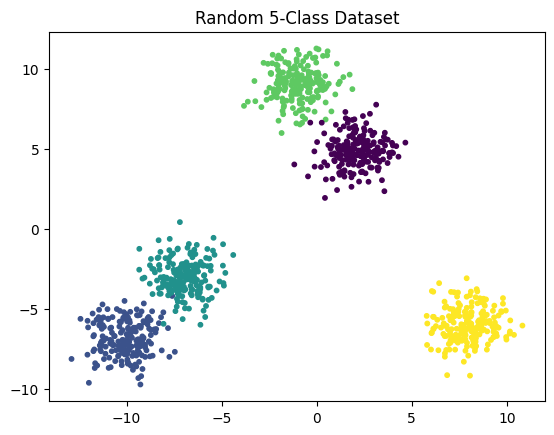

In [258]:
plt.scatter(X[:,0], X[:,1], c=y, s=10)
plt.title("Random 5-Class Dataset")
plt.show()


In [259]:
class NeuralNetwork(object):
    def __init__(self, input_dim=2, h1=32, h2=32, h3=32, output_dim=5, learning_rate=0.1):
        # weights & biases
        self.W1 = np.random.randn(input_dim, h1)*0.01
        self.b1 = np.zeros((1,h1))

        self.W2 = np.random.randn(h1, h2)*0.01
        self.b2 = np.zeros((1,h2))

        self.W3 = np.random.randn(h2, h3)*0.01
        self.b3 = np.zeros((1,h3))

        self.W4 = np.random.randn(h3, output_dim)*0.01
        self.b4 = np.zeros((1,output_dim))

        self.lr = learning_rate

    def sigmoid(self, x, der=False):
        if der: return x*(1-x)
        return 1/(1+np.exp(-x))

    def softmax(self, z):
        z = z - np.max(z, axis=1, keepdims=True)
        exp = np.exp(z)
        return exp/np.sum(exp, axis=1, keepdims=True)

    def one_hot(self, y, C):
        return np.eye(C)[y]

    def feedForward(self, X):
        self.X = X

        self.z1 = np.dot(X, self.W1)+self.b1
        self.a1 = self.sigmoid(self.z1)

        self.z2 = np.dot(self.a1, self.W2)+self.b2
        self.a2 = self.sigmoid(self.z2)

        self.z3 = np.dot(self.a2, self.W3)+self.b3
        self.a3 = self.sigmoid(self.z3)

        self.z4 = np.dot(self.a3, self.W4)+self.b4
        self.y_hat = self.softmax(self.z4)
        return self.y_hat

    def compute_loss(self, Y_onehot):
        N = Y_onehot.shape[0]
        log_probs = np.log(self.y_hat+1e-8)
        return -np.sum(Y_onehot*log_probs)/N

    def backPropagation(self, Y_onehot):
        N = Y_onehot.shape[0]

        dz4 = (self.y_hat - Y_onehot)/N
        dW4 = np.dot(self.a3.T, dz4)
        db4 = np.sum(dz4, axis=0, keepdims=True)

        da3 = np.dot(dz4, self.W4.T)
        dz3 = da3*self.sigmoid(self.a3, der=True)
        dW3 = np.dot(self.a2.T, dz3)
        db3 = np.sum(dz3, axis=0, keepdims=True)

        da2 = np.dot(dz3, self.W3.T)
        dz2 = da2*self.sigmoid(self.a2, der=True)
        dW2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1*self.sigmoid(self.a1, der=True)
        dW1 = np.dot(self.X.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # Update
        self.W4 -= self.lr*dW4; self.b4 -= self.lr*db4
        self.W3 -= self.lr*dW3; self.b3 -= self.lr*db3
        self.W2 -= self.lr*dW2; self.b2 -= self.lr*db2
        self.W1 -= self.lr*dW1; self.b1 -= self.lr*db1

    def train(self, X, y, epochs=1000):
        Y_onehot = self.one_hot(y, 5)
        for epoch in range(1, epochs+1):
            self.feedForward(X)
            loss = self.compute_loss(Y_onehot)
            self.backPropagation(Y_onehot)
            if epoch % 200 == 0 or epoch == 1:
                pred = self.predict(X)
                print(f"Epoch {epoch}, Loss={loss:.4f}, Acc={np.mean(pred==y):.4f}")

    def predict(self, X):
        probs = self.feedForward(X)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        return self.feedForward(X)

In [260]:
#Train
NN = NeuralNetwork()
NN.train(X_train, y_train, epochs=1000)


Epoch 1, Loss=1.6104, Acc=0.1925
Epoch 200, Loss=1.6089, Acc=0.2112
Epoch 400, Loss=1.6089, Acc=0.2112
Epoch 600, Loss=1.6089, Acc=0.2112
Epoch 800, Loss=1.6089, Acc=0.2112
Epoch 1000, Loss=1.6089, Acc=0.2112


In [261]:
#Accuracy
y_pred_test = NN.predict(X_test)
accuracy = np.mean(y_pred_test == y_test)
print("Test Accuracy:", accuracy)



Test Accuracy: 0.155


[[ 0 38  0  0  0]
 [ 0 31  0  0  0]
 [ 0 44  0  0  0]
 [ 0 46  0  0  0]
 [ 0 41  0  0  0]]


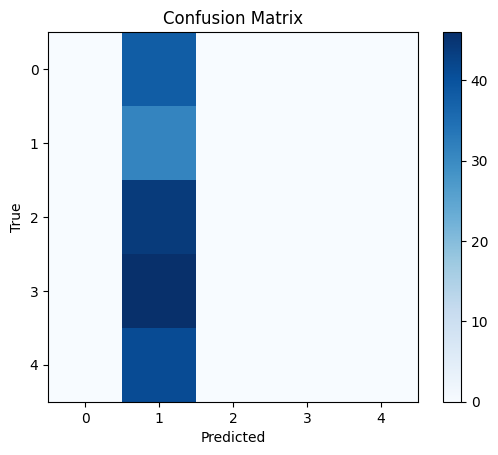

In [262]:
#Confusion Matrix
def confusion_matrix(y_true, y_pred, num_classes=5):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t,p in zip(y_true, y_pred):
        cm[t,p]+=1
    return cm

cm = confusion_matrix(y_test, y_pred_test, 5)
print(cm)

plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()


In [263]:
def precision_recall_f1_from_cm(cm):
    C = cm.shape[0]
    precisions = np.zeros(C); recalls = np.zeros(C); f1s = np.zeros(C)
    for k in range(C):
        tp = cm[k,k]; fp = cm[:,k].sum()-tp; fn = cm[k,:].sum()-tp
        precisions[k] = tp/(tp+fp+1e-8)
        recalls[k]    = tp/(tp+fn+1e-8)
        f1s[k]        = 2*precisions[k]*recalls[k]/(precisions[k]+recalls[k]+1e-8)
    return precisions, recalls, f1s


In [264]:
#precision
prec, rec, f1 = precision_recall_f1_from_cm(cm)
print("---- Precision ----")
for i in range(5):
    print(f"Class {i}: {prec[i]:.3f}")


---- Precision ----
Class 0: 0.000
Class 1: 0.155
Class 2: 0.000
Class 3: 0.000
Class 4: 0.000


In [265]:
#Recall
print("---- Recall ----")
for i in range(5):
    print(f"Class {i}: {rec[i]:.3f}")


---- Recall ----
Class 0: 0.000
Class 1: 1.000
Class 2: 0.000
Class 3: 0.000
Class 4: 0.000


In [266]:
#F1-score
print("---- F1-Score ----")
for i in range(5):
    print(f"Class {i}: {f1[i]:.3f}")


---- F1-Score ----
Class 0: 0.000
Class 1: 0.268
Class 2: 0.000
Class 3: 0.000
Class 4: 0.000


In [267]:
def roc_curve_binary(y_true_binary, y_score, num_thresholds=100):

    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    fprs = []
    tprs = []

    for thresh in thresholds:
        y_pred = (y_score >= thresh).astype(int)

        tp = np.sum((y_true_binary == 1) & (y_pred == 1))
        fp = np.sum((y_true_binary == 0) & (y_pred == 1))
        tn = np.sum((y_true_binary == 0) & (y_pred == 0))
        fn = np.sum((y_true_binary == 1) & (y_pred == 0))

        tpr = tp / (tp + fn + 1e-8)  # True Positive Rate
        fpr = fp / (fp + tn + 1e-8)  # False Positive Rate

        tprs.append(tpr)
        fprs.append(fpr)

    return np.array(fprs), np.array(tprs)


In [268]:
#AUC via Trapezoidal Rule
def auc_trapezoid(x, y):
    return np.trapz(y, x)


/tmp/ipython-input-2925139312.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y, x)


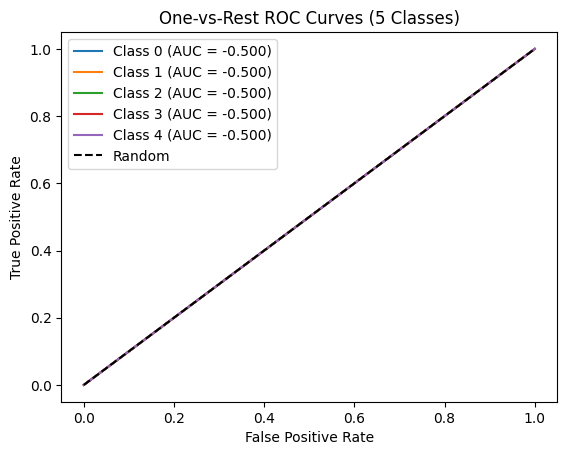

Class 0 AUC: -0.500
Class 1 AUC: -0.500
Class 2 AUC: -0.500
Class 3 AUC: -0.500
Class 4 AUC: -0.500


In [269]:
#ROC Curves and AUC for Each Class
probs_test = NN.predict_proba(X_test)  # (N_test, 5)
num_classes = 5

plt.figure()

for k in range(num_classes):
    y_true_binary = (y_test == k).astype(int)
    y_score = probs_test[:, k]

    fpr, tpr = roc_curve_binary(y_true_binary, y_score, num_thresholds=100)
    auc_k = auc_trapezoid(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Class {k} (AUC = {auc_k:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curves (5 Classes)")
plt.legend()
plt.show()

#print AUC
for k in range(num_classes):
    y_true_binary = (y_test == k).astype(int)
    y_score = probs_test[:, k]
    fpr, tpr = roc_curve_binary(y_true_binary, y_score, num_thresholds=100)
    auc_k = auc_trapezoid(fpr, tpr)
    print(f"Class {k} AUC: {auc_k:.3f}")
